In [24]:
from utils import *

# to connect plotly with pandas
import altair as alt
import cufflinks as cf  
import plotly           # to plot interactive visualizations
import chart_studio.plotly as py  #more charting options 
import plotly.express as px
#import matplotlib.pyplot as plt
%matplotlib inline


#to run plotly offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot   
init_notebook_mode(connected=True)
cf.go_offline()



## For Hypothesis Testing and Statistical Analysis:
- A <b>Good movie </b>is defined as having a score > 70.00 or having at least 1 Oscar Win or Oscar Nomination.
    - this is flagged as Good == 1 in the dataframe
- A <b>Financially successful</b> movie has Revenue = 3 * Budget
    - this is flagged as Success  == 1
    
## For Bayes:    
H0 = Good Movies are financially successful.<br>
HA = Good Movies are not financially successful.




In [25]:
bayes_df = pd.read_csv('data/movie_aggregate.csv')

## Setting up data for Hypothesis Test

### Hypothesis 

<b>H<sub>0</sub> : </b>Good movies are likely to have a high probability of financial success in the box office.<br>
<b>H<sub>A</sub> : </b>Good movies are likely to have a normal probability of financial success in the box office.

In [50]:
# Prep data for test - Using Critics_Choice 
df_good_c = bayes_df[bayes_df['Critics_Choice']==1] #Movies with Critics Score>= 7.5 
df_bad_c = bayes_df[bayes_df['Critics_Choice']==0]  #Movies with Critics Score < 7.5 

data1 = df_good_c.sample(n=300)['Profitable']
data2 = df_bad_c.sample(n=300)['Profitable']

In [51]:
# Prep data for test - Using Users_Pick
df_good_u = bayes_df[bayes_df['Users_Pick']==1] # Movies with User Score>= 7.5 
df_bad_u = bayes_df[bayes_df['Users_Pick']==0]  # Movies with User Score < 7.5 

data3 = df_good_u.sample(n=300)['Profitable']
data4 = df_bad_u.sample(n=300)['Profitable']

In [52]:
# Reverse - Testing if Profitable movies are good  - Critics

df_success1 = bayes_df[bayes_df['Profitable']==1] #   movies with ROI > 3xBudget
df_nsuccess1 = bayes_df[bayes_df['Profitable']==0] #  movies with ROI > 3xBudget

data5 = df_success1.sample(n=300)['Critics_Choice']
data6 = df_nsuccess1.sample(n=90)['Critics_Choice']

In [53]:
# Reverse - Testing if Profitable movies are good - Users

df_success2 = bayes_df[bayes_df['Profitable']==1] #   movies with ROI > 3xBudget
df_nsuccess2 = bayes_df[bayes_df['Profitable']==0] #  movies with ROI > 3xBudget

data7 = df_success2.sample(n=300)['Users_Pick']
data8 = df_nsuccess2.sample(n=90)['Users_Pick']

## Perform a Mann-Whitney U Test

In [49]:

def MannWhitneyU(d1,d2):
    m_results = stats.mannwhitneyu(data1, data2, alternative = 'two-sided')
    print("Mann-Whitney U Test Results:")
    if m_results[1] > 0.05:
        print(f'p-value is {m_results[1]}, which is greater than 0.05, therefore we reject the null hypothesis')
    else:
        print(f'p-value is {m_results[1]}, which is less than 0.05, therefore we do not reject the null hypothesis ')
    #p-value>0.05 fail to reject null hypothesis

MannWhitneyU(data1,data2)

Mann-Whitney U Test Results:
p-value is 0.2801701326815441, which is greater than 0.05, therefore we reject the null hypothesis


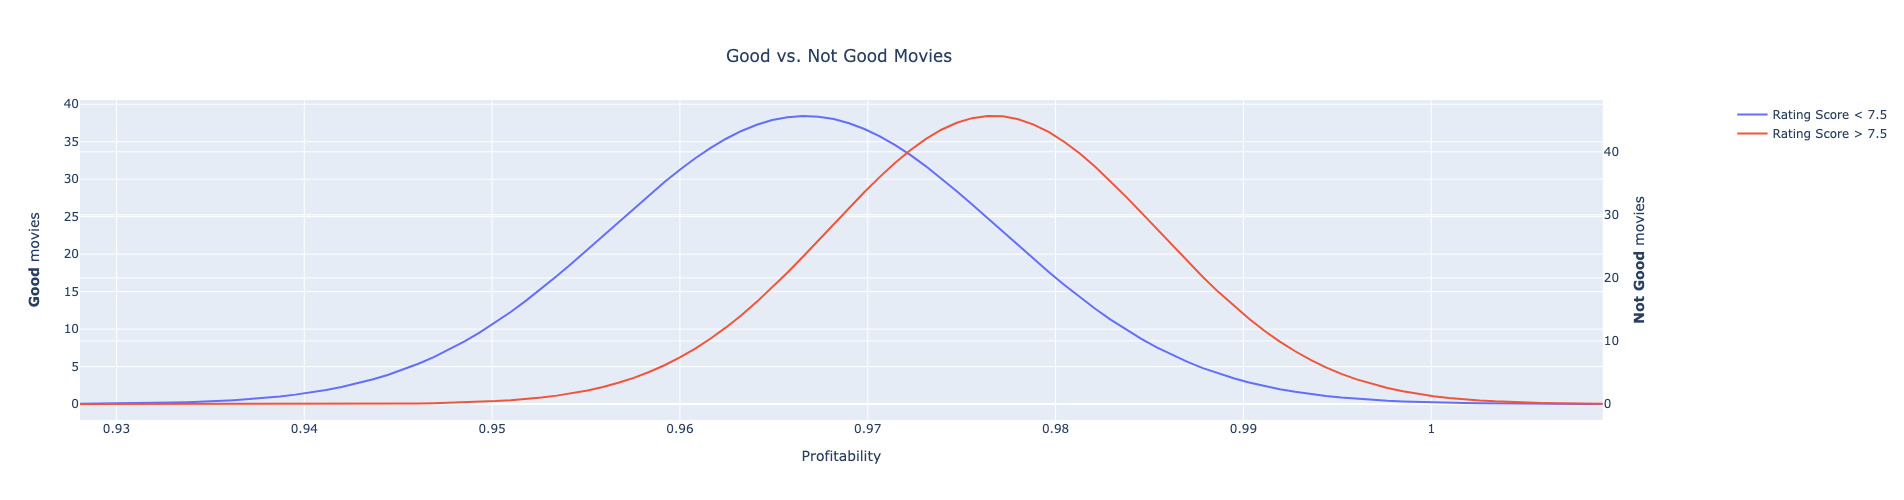

<Figure size 432x288 with 0 Axes>

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

good_dist = stats.norm(data1.mean(), data1.std()/np.sqrt(len(data1)))
bad_dist = stats.norm(data2.mean(), data2.std()/np.sqrt(len(data2)))
support = np.linspace(bad_dist.ppf(0.0001), good_dist.ppf(0.9999), 100)
good_pdf = good_dist.pdf(support)
bad_pdf = bad_dist.pdf(support)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=support, y=bad_pdf, name="Rating Score < 7.5"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=support, y=good_pdf, name="Rating Score > 7.5"),
    secondary_y=True,
)


# Add figure title
fig.update_layout(
    title={
        'text' : 'Good vs. Not Good Movies',
        'y':0.9,
        'x':0.5,
        'xanchor': 'right',
        'yanchor': 'top'},
    width=800, 
    height=500)
    
support = np.linspace(bad_dist.ppf(0.0001), good_dist.ppf(0.9999), 100)
# Set x-axis title
fig.update_xaxes(title_text="Profitability ")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Good</b> movies", secondary_y=False)
fig.update_yaxes(title_text="<b>Not Good</b> movies", secondary_y=True)
plt.savefig('images/conclusion.png', bbox_inches='tight');
fig.show()

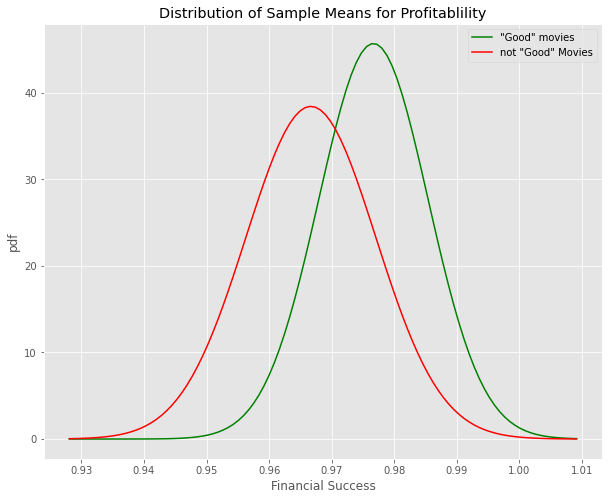

In [35]:
fig,ax = plt.subplots(figsize=(10,8))

good_dist = stats.norm(data1.mean(), data1.std()/np.sqrt(len(data1)))
bad_dist = stats.norm(data2.mean(), data2.std()/np.sqrt(len(data2)))

support = np.linspace(bad_dist.ppf(0.0001), good_dist.ppf(0.9999), 100)
good_pdf = good_dist.pdf(support)
bad_pdf = bad_dist.pdf(support)

ax.plot(support, good_pdf, color='green', label='"Good" movies')
ax.plot(support, bad_pdf, color='red', label='not "Good" Movies')
ax.legend()
ax.set_ylabel("pdf")
ax.set_xlabel('Financial Success')
ax.set_title("Distribution of Sample Means for Profitablility")
ax.figure.savefig('images/critics_success.png', bbox_inches='tight');

In [66]:
def compare_AB_conversion_rate(site_A_data, site_B_data, n=None):
    """compare the conversion rate of 2 different solutions A & B
    Args
    ----
        site_A_data (1-D np.array of shape (N,))
        site_B_data (1-D np.array of shape (N,))
        n (int): use a sub list of samples[:n]
    Return
    ------
        a plot comparing the conversion rate of site A and that of site B.
    """
    ax = plt.subplot()
    if n is None:
        n = min(len(site_A_data), len(site_A_data))
    site_A_samples = site_A_data[:n]
    site_B_samples = site_B_data[:n]
    plot_beta_from_data(site_A_samples, ax, label="Site A")
    plot_beta_from_data(site_B_samples, ax, label="Site B")
    plt.title(f'Comparing {n} Movies')
    plt.show()
    

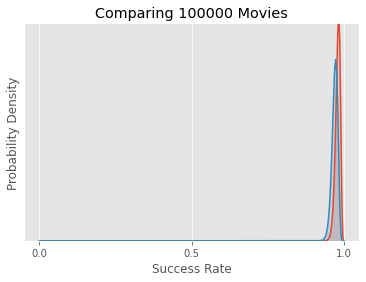

In [67]:
compare_AB_conversion_rate(data1,data2, n=100000)
#compare_AB_conversion_rate(data3,data4, n=100000)

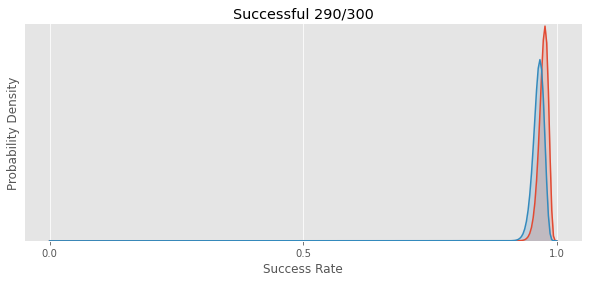

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_beta_from_data(data1, ax=ax)
plot_beta_from_data(data2, ax=ax)
ax.figure.savefig('images/critics_success2.png', bbox_inches='tight')


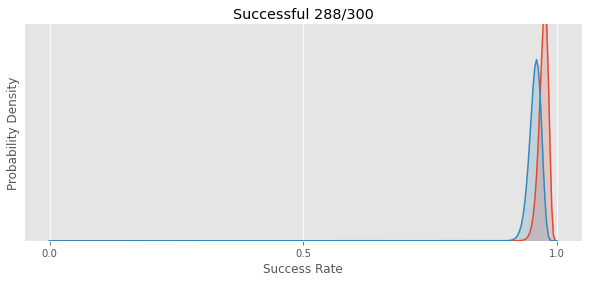

In [19]:
# user reviews
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_beta_from_data(data3, ax=ax)
plot_beta_from_data(data4, ax=ax)

(295, 7)

In [60]:
def runSimulationA(d1,d2,flag):
    num_simulations = 1000
    
    #Let's just grab our Alpha and betas from site_A
    alpha, beta = estimate_beta_params(d1)[:2]
    print(f'Movies with 7.5 score and/or have an oscar nod, alpha and beta {alpha, beta}')
    #Set up first distribution
    dist_A = stats.beta(alpha, beta)
    
    
    #Same steps for beta dist
    alpha, beta = estimate_beta_params(d2)[:2]
    print(f'Movies with below 7.5 score and no oscar nod, alpha and beta {alpha, beta}')
    dist_B = stats.beta(alpha, beta)
    
    #randomly sample 100_000 data points from each distribution
    simulated_A = dist_A.rvs(num_simulations)
    
    simulated_B = dist_B.rvs(num_simulations)
    
    if flag==True:
        print(f'Given the data, a "good" movie is {(simulated_A > simulated_B).mean()*100}% likely to have a high probability of it being financially successful. ')
    else:
        print(f'Given the data, a successful movie is {(simulated_A > simulated_B).mean()*100}% likely to have a high probability of it being good. ')     

## Running the Simulations: Are 'Good' Movies Profitable?

In [61]:
## Run simulation with Critics_Choice Data
runSimulationA(data1,data2,True)   

Movies with 7.5 score and/or have an oscar nod, alpha and beta (296, 6)
Movies with below 7.5 score and no oscar nod, alpha and beta (293, 9)
Given the data, a "good" movie is 78.4% likely to have a high probability of it being financially successful. 


In [62]:
## Run simulation with Users_Pick Data
runSimulationA(data5,data6,True)   

Movies with 7.5 score and/or have an oscar nod, alpha and beta (80, 222)
Movies with below 7.5 score and no oscar nod, alpha and beta (16, 76)
Given the data, a "good" movie is 98.0% likely to have a high probability of it being financially successful. 


## Testing the Inverse: Are Profitable Movies 'Good' ?

In [64]:
## Run simulation with Critics_Choice Data
runSimulationA(data5,data6,False)   

Movies with 7.5 score and/or have an oscar nod, alpha and beta (80, 222)
Movies with below 7.5 score and no oscar nod, alpha and beta (16, 76)
Given the data, a successful movie is 97.0% likely to have a high probability of it being good. 


In [65]:
## Run simulation with Users_Pick Data
runSimulationA(data7,data8,False)   

Movies with 7.5 score and/or have an oscar nod, alpha and beta (81, 221)
Movies with below 7.5 score and no oscar nod, alpha and beta (9, 83)
Given the data, a successful movie is 100.0% likely to have a high probability of it being good. 
